In [10]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
from PIL import Image
import tensorflow as tf
import os

def show_img(img, cmap=None, interpolation=None):
    fig = plt.figure()
    plt.imshow(img, cmap=cmap)
    display(fig)
    plt.close()
    
def print_stats(img, show=True, cmap=None, interpolation=None):
    print("Shape:\t", img.shape)
    print("Type: \t", img.dtype)
    if show:
        show_img(img, cmap, interpolation)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dati a disposizione


Abbiamo a disposizione triple di immagini:
1. L'immagine sinistra presa da una coppia stereo
2. La mappa di disparità, che associa i pixel dell'immagine 
   di destra con quelli di sinistra, ottenuta tramite un algoritmo di matching
3. La mappa di disparità "groundtruth", ovvero ottenuta tramite metodi reliable

La 1 e la 3 sono state estratte dal dataset kitti.

### $I_L$, $I_L(x,y)$ - Left Image
Immagine di altezza e larghezza variabile.
3 canali a 8bit. Codificata come uint8

Definizioni:

* $I_L$ : L'immagine. E' un tensore HxWx3

* $I_L(x,y)$ : Il pixel alla posizione $(x,y)$. E' un vettore di 3 valori

* $I_L(x,y,c)$ : Il valore dell'intensità del canale $c$ del pixel $(x,y)$

Analogamente viene definita $I_R$ per l'immagine di destra, che nonostante non venga utilizzata nell'esperimento, può essere utile per chiarimenti matematici formali.


Shape:	 (370, 1226, 3)
Type: 	 uint8


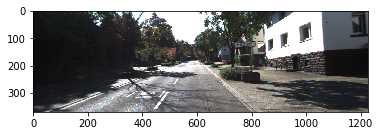

In [3]:
left = np.array(Image.open('../data/raw/kitti/left/000000_10.png'))
print_stats(left)

### $D, D(x,y)$ - Disparity Image / Mappa di disparità / Mappa depth / Immagine depth
Immagine di stessa altezza e larghezza della left. 1 canale a 8 bit

Definizioni:

* $D$ : La mappa di disparità. E' un tensore HxW di interi senza segno a 8 bit

* $D(x,y)$ : Il pixel alla posizione $(x,y)$. E' uno scalare. 
  Il valore indica che il pixel $I_L(x,y)$ è associato al pixel $I_R(x - D(x,y), y)$, ovvero che $I_L(x,y)$ e $I_R(x - D(x,y), y)$ sono la proiezione dello stesso punto $P$ sui sensori delle due fotocamere di sinistra e destra.
  
  Intuitivamente, un valore alto indica che il punto $P$ relativo al pixel $I_L(x,y)$ è vicino, 
  in quanto nell'immagine right appare molto più scostato verso sinistra rispetto che nell'immagine left.
  
  Analogamente, un valore basso indica che il punto $P$ relativo al pixel $I_L(x,y)$ è lontano, poichè non vi è molta differenza tra la proiezione di $P$ su $L$ e su $R$


Shape:	 (370, 1226)
Type: 	 uint8


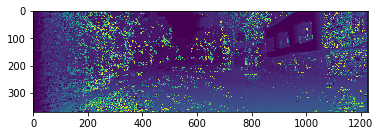

In [5]:
disp = np.array(Image.open('../data/raw/kitti/disparity/000000_10.png'))
print_stats(disp)

### Groundtruth Disparity
Immagine di stessa altezza e larghezza della left. 1 canale a 32 bit
A causa del metodo di acquisizione dell'immagine, la mappa non è densa, ovvero è definita solo per un insieme ristretto di pixel.

Definizioni:

* $D_{GT}$ : La mappa di disparità groundtruth. E' un tensore HxW di interi a 32 bit

* $D_{GT}(x,y)$ : Il pixel alla posizione $(x,y)$. E' uno scalare. Se $D_{GT}(x,y) == 0$, significa che non è disponibile un valore corretto per il pixel $D(x,y)$.

Shape:	 (370, 1226)
Type: 	 int32


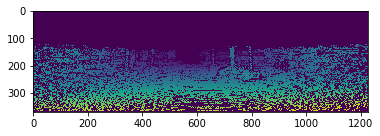

In [9]:
gt = np.array(Image.open('../data/raw/kitti/gt/000000_10.png'))
print_stats(gt)

# Obiettivi
L'obiettivo è trovare una mappa di confidenza per l'immagine depth, ovvero trovare una matrice che associa a ogni pixel dell'immagine depth la probabilità della sua correttezza.
Ciò viene ottenuto tramite una rete neurale supervisionata.

L'allenamento della rete richiederà una mappa di confidenza "groundtruth", ovvero la conoscenza a priori della confidenza del batch su cui si sta allenando la rete.

### $C_{GT}$ - Mappa di confidenza Groundtruth

Questa mappa di confidenza "groundtruth" può essere generata dal confronto tra le mappe disparity ($D$) e disparity groundtruth $D_{GT}$.
Se due pixel corrispondenti differiscono tra di loro per più di un valore di soglia definita a priori, il pixel viene considerato sbagliato.

#### Considerazione sui tipi
La disparity groundtruth è a 32 bit, e va confrontata con un'immagine a 8 bit. I valori verranno quindi divisi per un fattore di 256 e convertiti.
Poichè la mappa di confidenza è una mappa di probabilità, è conveniente definirla come matrice di float compresi tra 0 e 1.


#### Proposta 1: $C_{GT}$ binaria

Una possibile mappa di confidenza groundtrouth è una mappa di confidenza binaria, che associa un valore 1 a un pixel che è sicuramente giusto, e 0 a un pixel che è sicuramente sbagliato. 


$$ C_{gt}(threshold)(x,y) = \begin{cases}
  1 & \text{se } |D(x,y)-D_{GT}(x,y)| \le threshold  \\
  0 & \text{se } |D(x,y)-D_{GT}(x,y)| \gt threshold
\end{cases} $$

---
Domanda per il prof:
Come gestisco i pixel per cui non è definito un valore groundtruth?

- opzione 1: assegno il valore $0.5$ che rappresenta l'incertezza probabilistica (però potrebbe incentivare la rete a essere incerta) 
- opzione 2: non li considero affatto. Nel calcolo della loss utilizzo una maschera per ignorare i pixel sconosciuti
---

#### Proposta 2: $C_{GT}$ smooth

Nella $C_{GT}$ proposta 1, c'è la proprietà che aumentando la threshold i pixel giusti rimangono giusti, in quanto solo i pixel classificatti come sbagliati possono cambiare.
Ciò può essere sfruttato per creare una mappa di confidenza groundtruth "smooth" che è la combinazione di mappe di confidenza calcolate con threshold differenti, al fine di ottenere una mappa che rappresenta meglio le probabilità.